In [2]:
import numbers
import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
import docplex
import docplex.mp.model
import control
import control.matlab

import utility as util

COLORS = ['r', 'b', 'g', 'y', 'm', 'c', 'orange', 'purple', 'brown', 'teal', 'pink', 'turquoise']

In [66]:
def get_state_space_representation():
    """Get state-space representation of double integrator model."""
    # A, sys.A both have shape (4, 4)
    A = np.diag([1, 1], k=2)
    # B, sys.B both have shape (4, 2)
    B = np.concatenate((np.diag([0,0]), np.diag([1,1]),))
    # C has shape (2, 4)
    C = np.concatenate((np.diag([1,1]), np.diag([0,0]),), axis=1)
    # D has shape (2, 2)
    D = np.diag([0, 0])
    sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), 0.5)
    A = np.array(sys.A)
    B = np.array(sys.B)
    return (A, B)

def make_global_params(p_0_x, p_0_y, v_0_x, v_0_y):
    """Get Global LCSS parameters used across all loops"""
    params = util.AttrDict()
    params.M_big = 1000
    params.A, params.B = get_state_space_representation()
    # number of state variables x, number of input variables u
    # nx = 4, nu = 2
    params.nx, params.nu = params.B.shape
    bbox_lon, bbox_lat = 0.6, 0.4
    params.diag = np.sqrt(bbox_lon**2 + bbox_lat**2) / 2.
    # Prediction parameters
    params.T = 8
    params.L = 4 # number of faces of obstacle sets

    # Closed for solution of control without obstacles
    A, B, T, nx, nu = params.A, params.B, params.T, params.nx, params.nu
    # C1 has shape (nx, T*nx)
    C1 = np.zeros((nx, T*nx,))
    # C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
    C2 = np.kron(np.eye(T - 1), A)
    # C3 has shape (nx*(T - 1), nx)
    C3 = np.zeros(((T - 1)*nx, nx,))
    # C, Abar have shape (nx*T, nx*T)
    C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
    Abar = np.eye(T * nx) - C
    # Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
    Bbar = np.kron(np.eye(T), B)
    # Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
    Gamma = np.concatenate((np.zeros((nx, T*nu,)),
            np.linalg.solve(Abar, Bbar),))
    params.Abar = Abar
    params.Bbar = Bbar
    params.Gamma = Gamma

    # x0 : np.array
    #   Initial state
    x0 = np.array([p_0_x, p_0_y, v_0_x, v_0_y])
    params.p_0_x, params.p_0_y, params.v_0_x, params.v_0_y = x0
    A, T = params.A, params.T
    params.theta = np.angle(v_0_x + 1j*v_0_y)
    # params.v_lim = 8.33
    params.v_lim = 2.5
    # States_free_init has shape (nx*(T+1))
    params.States_free_init = np.concatenate([
            np.linalg.matrix_power(A, t) @ x0 for t in range(T+1)])
    return params

def compute_velocity_constraints(param, v_x, v_y):
    """Velocity states have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Street speed limit is 30 km/h == 8.33.. m/s"""
    v_lim = param.v_lim # is m/s
    theta = param.theta
    r = v_lim / 2
    v_1 = r
    v_2 = 0.75 * v_lim
    c1 = v_2*((v_x - r*np.cos(theta))*np.cos(theta) \
            + (v_y - r*np.sin(theta))*np.sin(theta))
    c2 = v_1*((v_y - r*np.sin(theta))*np.cos(theta) \
            - (v_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(v_1 * v_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

def compute_acceleration_constraints(param, u_x, u_y):
    """Accelaration control inputs have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Present performance cars are capable of going from 0 to 60 mph in under 5 seconds.
    Reference:
    https://en.wikipedia.org/wiki/0_to_60_mph"""
    theta = param.theta
    r = -2.5
    a_1 = 7.5
    a_2 = 5.0
    c1 = a_2*((u_x - r*np.cos(theta))*np.cos(theta) \
            + (u_y - r*np.sin(theta))*np.sin(theta))
    c2 = a_1*((u_y - r*np.sin(theta))*np.cos(theta) \
            - (u_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(a_1 * a_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

## Problem 1

In [1]:
x0 = np.array([3., 0., -0.3, 1.])
p_0_x, p_0_y, v_0_x, v_0_y = x0
params = make_global_params(p_0_x, p_0_y, v_0_x, v_0_y)
T = params.T + 2
params.O = 3
params.K = np.array([1, 2, 2])
params.N_traj = np.prod(params.K)
fig, ax = plt.subplots(figsize=(10, 10))

points = np.array([
        [1, 3],
        [3, 3.5],
        [5, 3]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-b');
lws = util.kronecker_mul_vectors(np.array([1.2, 1.]), np.linspace(1., 1.5, T))
vertex_set_1 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='blue', fc='none')
    ax.add_patch(patch)

points = np.array([
        [6, 3],
        [5, 3.5],
        [3, 2.],
        [1, 1.5]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-r');
lws = util.kronecker_mul_vectors(np.array([0.5, 1.2]), np.linspace(1., 2., T))
vertex_set_2 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='red', fc='none')
    ax.add_patch(patch)
    
points = np.array([
        [6, 3],
        [5, 3.3],
        [4, 3.1]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-y');
lws = util.kronecker_mul_vectors(np.array([0.5, 1.2]), np.linspace(1., 0.8, T))
vertex_set_3 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='y', fc='none')
    ax.add_patch(patch)

points = np.array([
        [6, 6],
        [5, 5.2],
        [3.1, 5]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-c');
lws = util.kronecker_mul_vectors(np.array([1.3, 1.]), np.linspace(1., 1.1, T))
vertex_set_4 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='c', fc='none')
    ax.add_patch(patch)

points = np.array([
        [6, 6],
        [2, 6.2],
        [0, 6]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-m');
lws = util.kronecker_mul_vectors(np.array([0.5, 0.5]), np.linspace(1., 3., T))
vertex_set_5 = util.place_rectangles_on_intep_curve(points, T, lws)

for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='m', fc='none')
    ax.add_patch(patch)

ax.scatter(p_0_x, p_0_y, marker='*', c='k', s=100)
ax.arrow(p_0_x, p_0_y, v_0_x, v_0_y, color='k', head_width=0.09)

ax.set_aspect('equal')
ax.set_xlim([-1, 8])
ax.set_ylim([-1, 8])

vertex_superset = [
        [    # OV 1
            vertex_set_1
        ], [ # OV 2
            vertex_set_2,
            vertex_set_3
        ], [ # OV 3
            vertex_set_4,
            vertex_set_5
        ]]

N_traj, T, O = params.N_traj, params.T, params.O
A_unions = np.empty((N_traj, T, O,), dtype=object).tolist()
b_unions = np.empty((N_traj, T, O,), dtype=object).tolist()
traj_idx = 0
for _vertex_set_1 in vertex_superset[0]:
    for _vertex_set_2 in vertex_superset[1]:
        for _vertex_set_3 in vertex_superset[2]:
            for t in range(T):
                for ov_idx, _vertices in enumerate([
                        _vertex_set_1[t], _vertex_set_2[t], _vertex_set_3[t]]):
                    A, b = util.vertices_to_halfspace_representation(_vertices)
                    A_unions[traj_idx][t][ov_idx] = A
                    b_unions[traj_idx][t][ov_idx] = b
            traj_idx += 1

NameError: name 'np' is not defined

In [68]:
"""Apply motion planning problem"""
N_traj, L, T, K, O, Gamma, nu, nx = params.N_traj, params.L, params.T, params.K, \
        params.O, params.Gamma, params.nu, params.nx
model = docplex.mp.model.Model(name='obstacle_avoidance')
# set up controls variables for each trajectory
u = np.array(model.continuous_var_list(N_traj*T*nu, lb=-8., ub=8., name='control'))
Delta = np.array(model.binary_var_list(O*L*N_traj*T, name='delta')).reshape(N_traj, T, O, L)

# U has shape (N_traj, T*nu)
U = u.reshape(N_traj, -1)
# Gamma has shape (nx*(T + 1), nu*T) so X has shape (N_traj, nx*(T + 1))
X = util.obj_matmul(U, Gamma.T)
# X, U have shapes (N_traj, T, nx) and (N_traj, T, nu) resp.
X = (X + params.States_free_init).reshape(N_traj, -1, nx)[..., 1:, :]
U = U.reshape(N_traj, -1, nu)

for _U, _X in zip(U, X):
    # _X, _U have shapes (T, nx) and (T, nu) resp.
    p_x, p_y = _X[..., 0], _X[..., 1]
    v_x, v_y = _X[..., 2], _X[..., 3]
    u_x, u_y = _U[..., 0], _U[..., 1]
    model.add_constraints(compute_velocity_constraints(params, v_x, v_y))
    model.add_constraints(compute_acceleration_constraints(params, u_x, u_y))

# set up obstacle constraints
M_big, N_traj, T, diag = params.M_big, params.N_traj, params.T, params.diag
for n in range(N_traj):
    # for each obstacle/trajectory
    A_union, b_union = A_unions[n], b_unions[n]
    for t in range(T):
        # for each timestep
        As, bs = A_union[t], b_union[t]
        for o, (A, b) in enumerate(zip(As, bs)):
            lhs = util.obj_matmul(A, X[n,t,:2]) + M_big*(1 - Delta[n,t,o])
            rhs = b + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[n,t,o]) >= 1)

# set up coinciding constraints
N_coincide = 1
for t in range(0, N_coincide):
    for x1, x2 in util.pairwise(X[:,t]):
        model.add_constraints([l == r for (l,r) in zip(x1, x2)])

# start from current vehicle position and minimize the objective
p_0_x, p_0_y, T, N_traj = params.p_0_x, params.p_0_y, params.T, params.N_traj
goal_x, goal_y = 3, 9
goal = np.array([goal_x, goal_y])
cost = 0.
for n in range(N_traj):
    for t in range(T):
        cost += (X[n, t,0] - goal_x)**2 + (X[n, t,1] - goal_y)**2
        cost += 0.05*t*(X[n, t,2]**2 + X[n, t,3]**2)

model.minimize(cost)
# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 98 rows and 72 columns.
MIQP Presolve modified 996 coefficients.
Reduced MIQP has 650 rows, 376 columns, and 5300 nonzeros.
Reduced MIQP has 312 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 512 nonzeros.
Presolve time = 0.00 sec. (2.00 ticks)
Probing fixed 8 vars, tightened 0 bounds.
Probing time = 0.00 sec. (4.36 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 8 rows and 8 columns.
MIQP Presolve modified 312 coefficients.
Aggregator did 4 substitutions.
Reduced MIQP has 638 rows, 364 columns, and 5236 nonzeros.
Reduced MIQP has 300 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 512 nonzeros.
Presolve time = 0.00 sec. (1.96 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.00 sec. (1.23 ticks)
Clique table members: 86

In [69]:
f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)
U_warmstart = U
Delta_warmstart = Delta

In [70]:
X_star.shape

(4, 8, 4)

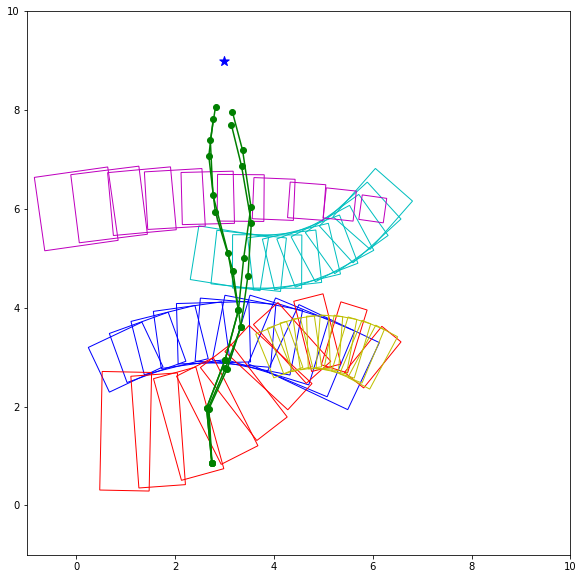

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='b', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='r', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='y', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='c', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='m', fc='none')
    ax.add_patch(patch)

for n in range(N_traj):
    _X = X_star[n, :, :2]
    ax.plot(*_X.T, '-go')
ax.scatter(*goal, marker='*', s=100, c='b')
ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
None

## Problem 2

### Using MCC

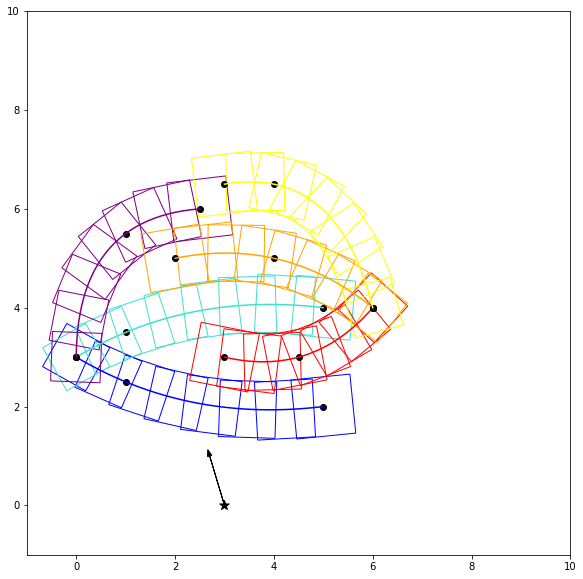

In [94]:
def plot_and_extract_vertices(ax, points, T, color='blue'):
    ax.plot(*points.T, 'ok');
    interp_points = util.interp_and_sample(points, 30)
    ax.plot(*interp_points.T, '-', c=color);
    lws = util.kronecker_mul_vectors(np.array([1., 1.]), np.linspace(1., 1.2, T))
    vertex_set = util.place_rectangles_on_intep_curve(points, T, lws)

    for vertices in vertex_set:
        patch = patches.Polygon(vertices, closed=True, color=color, fc='none')
        ax.add_patch(patch)
    return vertex_set

x0 = np.array([3., 0., -0.3, 1.])
p_0_x, p_0_y, v_0_x, v_0_y = x0
params = make_global_params(p_0_x, p_0_y, v_0_x, v_0_y)
T = params.T
params.O = 2
params.K = np.array([3, 3])
params.N_traj = np.prod(params.K)
fig, ax = plt.subplots(figsize=(10, 10))

points = np.array([
        [0, 3],
        [1, 2.5],
        [5, 2]])
vertex_set_1 = plot_and_extract_vertices(ax, points, T, color='blue')

points = np.array([
        [0, 3],
        [1, 3.5],
        [5, 4]])
vertex_set_2 = plot_and_extract_vertices(ax, points, T, color='turquoise')

points = np.array([
        [0, 3],
        [1, 5.5],
        [2.5, 6]])
vertex_set_3 = plot_and_extract_vertices(ax, points, T, color='purple')

points = np.array([
        [6, 4],
        [4.5, 3],
        [3, 3]])
vertex_set_4 = plot_and_extract_vertices(ax, points, T, color='red')

points = np.array([
        [6, 4],
        [4, 5],
        [2, 5]])
vertex_set_5 = plot_and_extract_vertices(ax, points, T, color='orange')

points = np.array([
        [6, 4],
        [4, 6.5],
        [3, 6.5]])
vertex_set_6 = plot_and_extract_vertices(ax, points, T, color='yellow')

ax.scatter(p_0_x, p_0_y, marker='*', c='k', s=100)
ax.arrow(p_0_x, p_0_y, v_0_x, v_0_y, color='k', head_width=0.09)

ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])

vertex_superset = [
        [    # OV 1
            vertex_set_1,
            vertex_set_2,
            vertex_set_3
        ], [ # OV 2
            vertex_set_4,
            vertex_set_5,
            vertex_set_6
        ]]

N_traj, T, O = params.N_traj, params.T, params.O
A_unions = np.empty((N_traj, T, O,), dtype=object).tolist()
b_unions = np.empty((N_traj, T, O,), dtype=object).tolist()
traj_idx = 0
for _vertex_set_1 in vertex_superset[0]:
    for _vertex_set_2 in vertex_superset[1]:
        for t in range(T):
            for ov_idx, _vertices in enumerate([
                    _vertex_set_1[t], _vertex_set_2[t]]):
                
                A, b = util.vertices_to_halfspace_representation(_vertices)
                A_unions[traj_idx][t][ov_idx] = A
                b_unions[traj_idx][t][ov_idx] = b
        traj_idx += 1

In [95]:
"""Apply motion planning problem"""
N_traj, L, T, K, O, Gamma, nu, nx = params.N_traj, params.L, params.T, params.K, \
        params.O, params.Gamma, params.nu, params.nx
model = docplex.mp.model.Model(name='obstacle_avoidance')
# set up controls variables for each trajectory
u = np.array(model.continuous_var_list(N_traj*T*nu, lb=-8., ub=8., name='control'))
Delta = np.array(model.binary_var_list(O*L*N_traj*T, name='delta')).reshape(N_traj, T, O, L)

# U has shape (N_traj, T*nu)
U = u.reshape(N_traj, -1)
# Gamma has shape (nx*(T + 1), nu*T) so X has shape (N_traj, nx*(T + 1))
X = util.obj_matmul(U, Gamma.T)
# X, U have shapes (N_traj, T, nx) and (N_traj, T, nu) resp.
X = (X + params.States_free_init).reshape(N_traj, -1, nx)[..., 1:, :]
U = U.reshape(N_traj, -1, nu)

for _U, _X in zip(U, X):
    # _X, _U have shapes (T, nx) and (T, nu) resp.
    p_x, p_y = _X[..., 0], _X[..., 1]
    v_x, v_y = _X[..., 2], _X[..., 3]
    u_x, u_y = _U[..., 0], _U[..., 1]
    model.add_constraints(compute_velocity_constraints(params, v_x, v_y))
    model.add_constraints(compute_acceleration_constraints(params, u_x, u_y))

# set up obstacle constraints
M_big, N_traj, T, diag = params.M_big, params.N_traj, params.T, params.diag
for n in range(N_traj):
    # for each obstacle/trajectory
    A_union, b_union = A_unions[n], b_unions[n]
    for t in range(T):
        # for each timestep
        As, bs = A_union[t], b_union[t]
        for o, (A, b) in enumerate(zip(As, bs)):
            lhs = util.obj_matmul(A, X[n,t,:2]) + M_big*(1 - Delta[n,t,o])
            rhs = b + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[n,t,o]) >= 1)

# set up coinciding constraints
goal_x, goal_y = 3, 9
N_coincide = 1
for t in range(0, N_coincide):
    for x1, x2 in util.pairwise(X[:,t]):
        model.add_constraints([l == r for (l,r) in zip(x1, x2)])

# start from current vehicle position and minimize the objective
p_0_x, p_0_y, T, N_traj = params.p_0_x, params.p_0_y, params.T, params.N_traj
goal = np.array([goal_x, goal_y])
cost = 0.
for n in range(N_traj):
    for t in range(T):
        cost += (X[n, t,0] - goal_x)**2 + (X[n, t,1] - goal_y)**2
        cost += 0.05*t*(X[n, t,2]**2 + X[n, t,3]**2)

model.minimize(cost)
# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIQP Presolve eliminated 139 rows and 96 columns.
MIQP Presolve modified 1482 coefficients.
Aggregator did 6 substitutions.
Reduced MIQP has 1183 rows, 618 columns, and 9074 nonzeros.
Reduced MIQP has 474 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 1152 nonzeros.
Presolve time = 0.01 sec. (3.90 ticks)
Probing fixed 6 vars, tightened 0 bounds.
Probing time = 0.00 sec. (6.31 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 6 rows and 6 columns.
MIQP Presolve modified 492 coefficients.
Aggregator did 3 substitutions.
Reduced MIQP has 1174 rows, 609 columns, and 9026 nonzeros.
Reduced MIQP has 465 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 1152 nonzeros.
Presolve time = 0.00 sec. (2.99 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.00 sec

In [96]:
f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)
U_warmstart = U
Delta_warmstart = Delta
X_star.shape

(9, 8, 4)

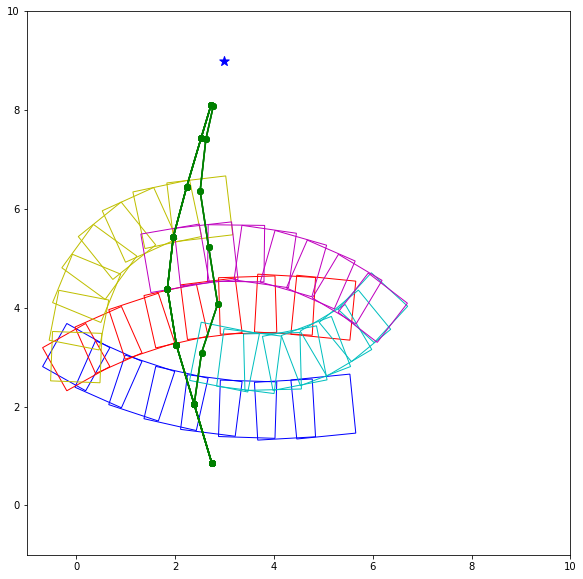

In [97]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='b', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='r', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='y', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='c', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='m', fc='none')
    ax.add_patch(patch)

for n in range(N_traj):
    _X = X_star[n, :, :2]
    ax.plot(*_X.T, '-go')
ax.scatter(*goal, marker='*', s=100, c='b')
ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
None

### Problem 2 PMCC

In [110]:
"""Apply motion planning problem"""
N_select = 5
goal_x, goal_y = 3, 4
N_coincide = 1
subtraj_indices = np.random.choice(np.arange(params.N_traj), size=N_select, replace=False)
N_traj, L, T, K, O, Gamma, nu, nx = params.N_traj, params.L, params.T, params.K, \
        params.O, params.Gamma, params.nu, params.nx
model = docplex.mp.model.Model(name='obstacle_avoidance')
# set up controls variables for each trajectory
u = np.array(model.continuous_var_list(N_select*T*nu, lb=-8., ub=8., name='control'))
Delta = np.array(model.binary_var_list(O*L*N_select*T, name='delta')).reshape(N_select, T, O, L)

# U has shape (N_select, T*nu)
U = u.reshape(N_select, -1)
# Gamma has shape (nx*(T + 1), nu*T) so X has shape (N_select, nx*(T + 1))
X = util.obj_matmul(U, Gamma.T)
# X, U have shapes (N_select, T, nx) and (N_select, T, nu) resp.
X = (X + params.States_free_init).reshape(N_select, -1, nx)[..., 1:, :]
U = U.reshape(N_select, -1, nu)

for _U, _X in zip(U, X):
    # _X, _U have shapes (T, nx) and (T, nu) resp.
    p_x, p_y = _X[..., 0], _X[..., 1]
    v_x, v_y = _X[..., 2], _X[..., 3]
    u_x, u_y = _U[..., 0], _U[..., 1]
    model.add_constraints(compute_velocity_constraints(params, v_x, v_y))
    model.add_constraints(compute_acceleration_constraints(params, u_x, u_y))

# set up obstacle constraints
M_big, T, diag = params.M_big, params.T, params.diag
for n, i in enumerate(subtraj_indices):
    # select outerapprox. by index i
    A_union, b_union = A_unions[i], b_unions[i]
    for t in range(T):
        # for each timestep
        As, bs = A_union[t], b_union[t]
        for o, (A, b) in enumerate(zip(As, bs)):
            lhs = util.obj_matmul(A, X[n,t,:2]) + M_big*(1 - Delta[n,t,o])
            rhs = b + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[n,t,o]) >= 1)

# set up coinciding constraints
for t in range(0, N_coincide):
    for x1, x2 in util.pairwise(X[:,t]):
        model.add_constraints([l == r for (l,r) in zip(x1, x2)])

# start from current vehicle position and minimize the objective
p_0_x, p_0_y, T = params.p_0_x, params.p_0_y, params.T
goal = np.array([goal_x, goal_y])
cost = 0.
for n in range(N_select):
    for t in range(T):
        cost += (X[n, t,0] - goal_x)**2 + (X[n, t,1] - goal_y)**2
        cost += 0.05*t*(X[n, t,2]**2 + X[n, t,3]**2)

model.minimize(cost)
# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIQP Presolve eliminated 76 rows and 53 columns.
MIQP Presolve modified 826 coefficients.
Aggregator did 3 substitutions.
Reduced MIQP has 657 rows, 344 columns, and 5042 nonzeros.
Reduced MIQP has 264 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 640 nonzeros.
Presolve time = 0.00 sec. (2.21 ticks)
Probing fixed 4 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.35 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 4 rows and 4 columns.
MIQP Presolve modified 273 coefficients.
Aggregator did 2 substitutions.
Reduced MIQP has 651 rows, 338 columns, and 5010 nonzeros.
Reduced MIQP has 258 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 640 nonzeros.
Presolve time = 0.00 sec. (1.71 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.00 sec. (0.8

In [111]:
f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)
U_warmstart = U
Delta_warmstart = Delta
X_star.shape

(5, 8, 4)

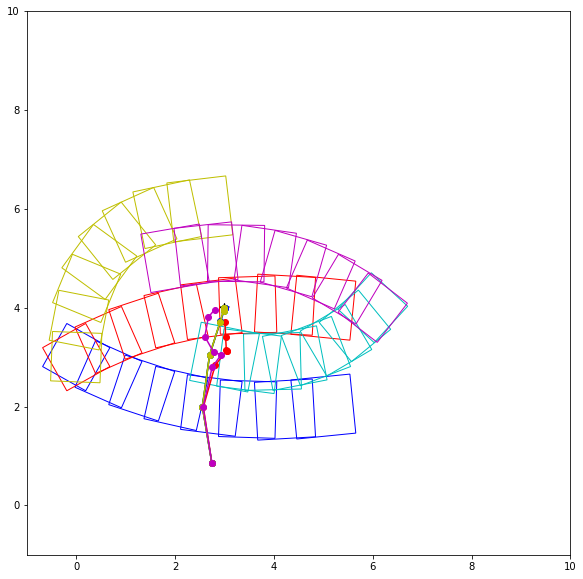

In [118]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='b', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='r', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='y', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='c', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='m', fc='none')
    ax.add_patch(patch)

for n in range(N_select):
    _X = X_star[n, :, :2]
    ax.plot(*_X.T, '-o', color=COLORS[n])
ax.scatter(*goal, marker='*', s=100, c='k')
ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
None